# Blackbird Dataset
## Description
Initial investigation into [MIT's Blackbird Dataset](http://blackbird-dataset.mit.edu/BlackbirdDatasetData/dice/yawForward/maxSpeed1p0/csv/?prefix=BlackbirdDatasetData/) which involves a quadcopter flying in a flight cage. This dataset has both a [paper](https://arxiv.org/abs/1810.01987) and [Github](https://github.com/mit-fast/Blackbird-Dataset) associated with it.

## Data Exploration

Using the Pandas library, a singular flight data set will be downloaded into a pandas dataframe using a url. Due to the size of the datasets, csv files will be looked at individually. Ordering is:

1. State - Vicon system
        * Global position
        * Rotation angles (Quaternians)
2. IMU - Xsens MTi-3 IMU
        * Linear Acceleration in Body frame [m/s]
        * Rotations in Body frame [rps](?)
3. PWM
        * Individual Motor PWMS [1000 - 2000 nanosec]
4. Rotor RPM
        * Motors are samples 1-4 with stamps noted
5. Pose Ref
        * Reference Position and Orientation (?)
### State CSV

In [1]:
import pandas as pd
import io
import requests

urlhead = "http://blackbird-dataset.mit.edu/BlackbirdDatasetData/" + \
          "figure8/" + \
          "yawConstant/" +\
          "maxSpeed0p5/csv/"

url = urlhead + "blackbird_slash_state.csv"
#contents = requests.get(url).content
pos_and_orien = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
pos_and_orien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 17 columns):
rosbagTimestamp    77287 non-null int64
header             0 non-null float64
seq                77287 non-null int64
stamp              0 non-null float64
secs               77287 non-null int64
nsecs              77287 non-null int64
frame_id           77287 non-null object
pose               0 non-null float64
position           0 non-null float64
x                  77287 non-null float64
y                  77287 non-null float64
z                  77287 non-null float64
orientation        0 non-null float64
x.1                77287 non-null float64
y.1                77287 non-null float64
z.1                77287 non-null float64
w                  77287 non-null float64
dtypes: float64(12), int64(4), object(1)
memory usage: 10.0+ MB


In [2]:
pos_and_orien.head()

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,position,x,y,z,orientation,x.1,y.1,z.1,w
0,1526617312016142000,NaN,1,NaN,1526617312,16142000,"""mocap""",NaN,NaN,-3.393845,0.261713,-0.926976,NaN,-0.008990,0.024020,-0.031950,0.999160
1,1526617312018921000,NaN,4,NaN,1526617312,18921000,"""mocap""",NaN,NaN,-3.393903,0.261800,-0.926810,NaN,-0.008838,0.024517,-0.031534,0.999163
2,1526617312021699000,NaN,6,NaN,1526617312,21699000,"""mocap""",NaN,NaN,-3.393929,0.261766,-0.927067,NaN,-0.009055,0.023970,-0.031980,0.999160
3,1526617312024477000,NaN,8,NaN,1526617312,24477000,"""mocap""",NaN,NaN,-3.393887,0.261701,-0.926861,NaN,-0.008776,0.023786,-0.031966,0.999167
4,1526617312027254000,NaN,11,NaN,1526617312,27254000,"""mocap""",NaN,NaN,-3.393841,0.261676,-0.926848,NaN,-0.008549,0.024100,-0.031734,0.999169


In [3]:
#Adjustments
#Adjust timescale
sec_start_ref = pos_and_orien.at[1,'secs']
nsec_start_ref = pos_and_orien.at[1,'nsecs']

#pos_and_orien['secs'] = pos_and_orien['secs'] - sec_start_ref
#pos_and_orien['nsecs'] = pos_and_orien['nsecs'] - nsec_start_ref

# Drop empty columns
pos_and_orien = pos_and_orien.drop(['header',\
                                    'stamp',\
                                    'pose',\
                                    'position',\
                                    'orientation'],\
                                    axis=1)
#Rename variables and add units
pos_and_orien = pos_and_orien.rename(columns={"x" : "px_[m]",\
                                              "y" : "py_[m]",\
                                              "z" : "pz_[m]",\
                                              "x.1" : "qx",\
                                              "y.1" : "qy",\
                                              "z.1" : "qz",\
                                              "w" : "qw"})

pos_and_orien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 12 columns):
rosbagTimestamp    77287 non-null int64
seq                77287 non-null int64
secs               77287 non-null int64
nsecs              77287 non-null int64
frame_id           77287 non-null object
px_[m]             77287 non-null float64
py_[m]             77287 non-null float64
pz_[m]             77287 non-null float64
qx                 77287 non-null float64
qy                 77287 non-null float64
qz                 77287 non-null float64
qw                 77287 non-null float64
dtypes: float64(7), int64(4), object(1)
memory usage: 7.1+ MB


In [4]:
import math

# Transform quaternions into Euler angles
for i in range(pos_and_orien.index[-1]):
    q0 = pos_and_orien.at[i, 'qw']
    q1 = pos_and_orien.at[i, 'qx']
    q2 = pos_and_orien.at[i, 'qy']
    q3 = pos_and_orien.at[i, 'qz']
    pos_and_orien.at[i,'roll_[rad]'] = math.atan2(2*(q0*q1 + q2*q3),\
                                                  q0*q0 + q3*q3 - q1*q1 - q2*q2)
    pos_and_orien.at[i,'pitch_[rad]'] = math.asin(2*(q0*q2 - q3*q1))
    pos_and_orien.at[i,'yaw_[rad]'] = math.atan2(2*(q0*q3 + q1*q2),\
                                                  q0*q0 + q1*q1 - q3*q3 - q2*q2)

<IPython.core.display.Javascript object>


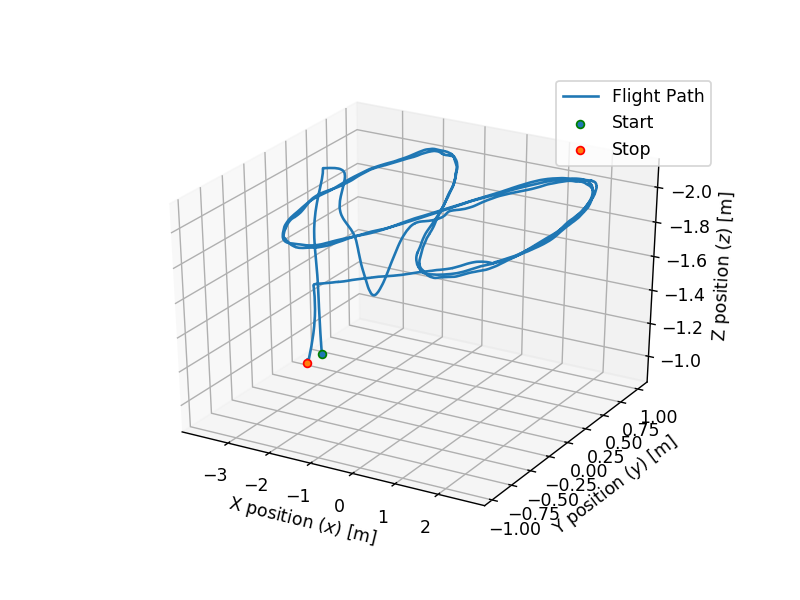

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.invert_zaxis()

Npao = pos_and_orien.index[-1]

ax.plot(pos_and_orien['px_[m]'],\
        pos_and_orien['py_[m]'],\
        pos_and_orien['pz_[m]'],\
        label="Flight Path")
ax.scatter(pos_and_orien.at[1,'px_[m]'],\
           pos_and_orien.at[1,'py_[m]'],\
           pos_and_orien.at[1,'pz_[m]'],\
           marker="o", edgecolor = "g", label="Start")
ax.scatter(pos_and_orien.at[Npao,'px_[m]'],\
           pos_and_orien.at[Npao,'py_[m]'],\
           pos_and_orien.at[Npao,'pz_[m]'],\
           marker="o", edgecolor = "r", label="Stop")
ax.set_xlabel("X position ($x$) [m]")
ax.set_ylabel("Y position ($y$) [m]")
ax.set_zlabel("Z position ($z$) [m]")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


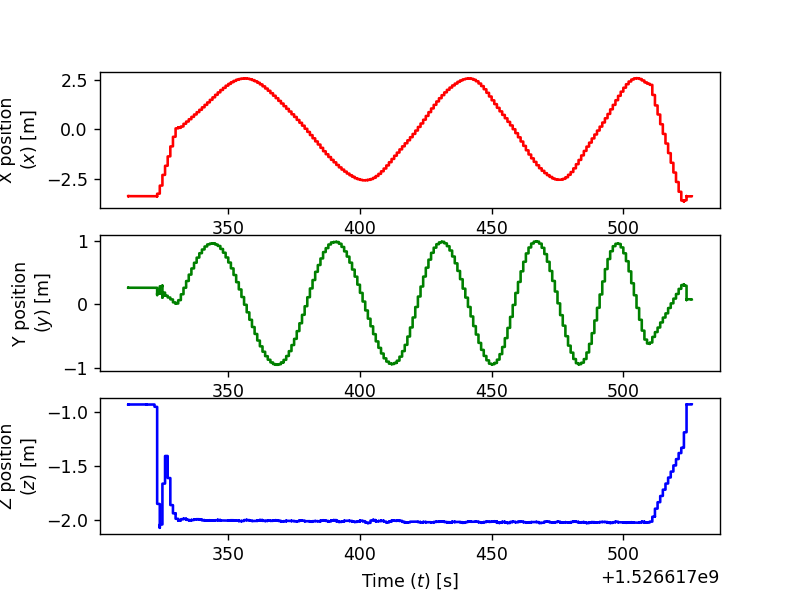

In [6]:
fig,ax = plt.subplots(3,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['px_[m]'], color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['py_[m]'], color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['pz_[m]'], color='b')

ax[0].set_ylabel("X position\n($x$) [m]")
ax[1].set_ylabel("Y position\n($y$) [m]")
ax[2].set_ylabel("Z position\n($z$) [m]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

<IPython.core.display.Javascript object>


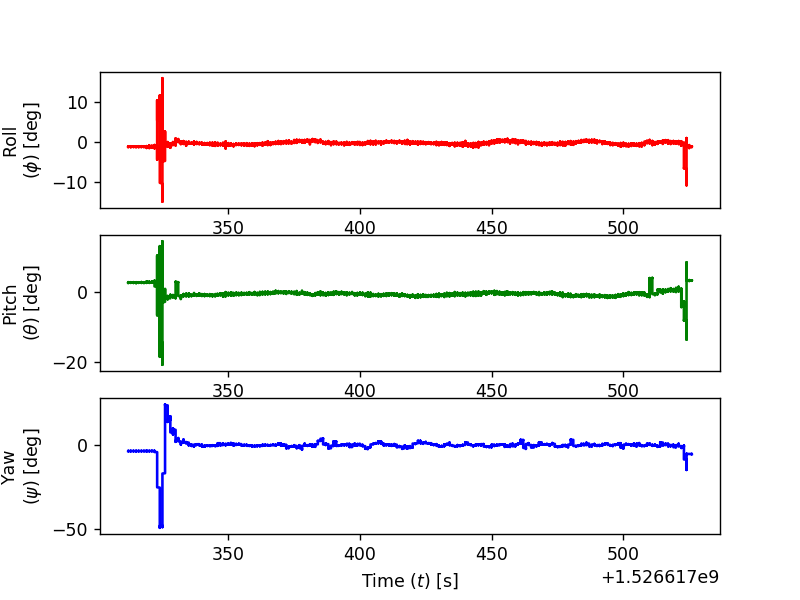

In [7]:
import math

fig,ax = plt.subplots(3,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['roll_[rad]'].apply(math.degrees), color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['pitch_[rad]'].apply(math.degrees), color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['yaw_[rad]'].apply(math.degrees), color='b')

ax[0].set_ylabel("Roll\n($\phi$) [deg]")
ax[1].set_ylabel("Pitch\n($\\theta$) [deg]")
ax[2].set_ylabel("Yaw\n($\psi$) [deg]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

In [8]:
pos_and_orien['|deltax|'] = pos_and_orien['px_[m]'].diff().apply(math.fabs)
pos_and_orien['|deltay|'] = pos_and_orien['py_[m]'].diff().apply(math.fabs)
pos_and_orien['|deltaz|'] = pos_and_orien['pz_[m]'].diff().apply(math.fabs)

<IPython.core.display.Javascript object>


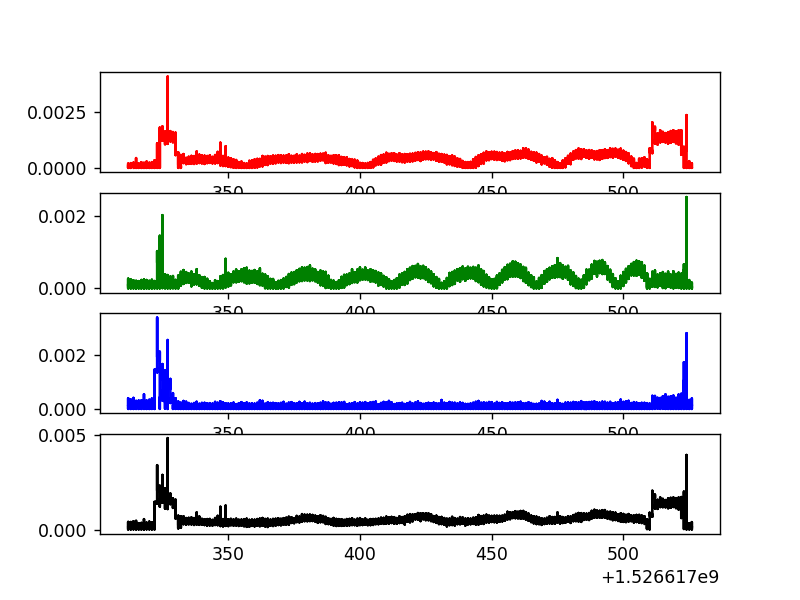

In [9]:
import numpy as np

fig,ax = plt.subplots(4,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['|deltax|'], color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['|deltay|'], color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['|deltaz|'], color='b')
ax[3].plot(pos_and_orien['secs'], (pos_and_orien['|deltax|'].apply(np.square) +\
                                   pos_and_orien['|deltay|'].apply(np.square) +\
                                   pos_and_orien['|deltaz|'].apply(np.square)).apply(np.sqrt),\
           color='k')

plt.show()

### IMU

In [10]:
url = urlhead + "blackbird_slash_imu.csv"
imu_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
imu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21298 entries, 0 to 21297
Data columns (total 23 columns):
rosbagTimestamp                   21298 non-null int64
header                            0 non-null float64
seq                               21298 non-null int64
stamp                             0 non-null float64
secs                              21298 non-null int64
nsecs                             21298 non-null int64
frame_id                          21298 non-null object
orientation                       0 non-null float64
x                                 21298 non-null float64
y                                 21298 non-null float64
z                                 21298 non-null float64
w                                 21298 non-null float64
orientation_covariance            21298 non-null object
angular_velocity                  0 non-null float64
x.1                               21298 non-null float64
y.1                               21298 non-null float64
z.1  

In [11]:
#Adjustments
#Adjust timescale
#imu_df['secs'] = imu_df['secs'] - sec_start_ref
#imu_df['nsecs'] = imu_df['nsecs'] - nsec_start_ref

# Drop empty columns
imu_df = imu_df.drop(['header',\
                      'stamp',\
                      'orientation',\
                      'angular_velocity',\
                      'linear_acceleration'],\
                     axis=1)
#Rename variables and add units
imu_df = imu_df.rename(columns={"x" : "qx",\
                                "y" : "qy",\
                                "z" : "qz",\
                                "w" : "qw",\
                                "x.1" : "omegax_[rps]",\
                                "y.1" : "omegay_[rps]",\
                                "z.1" : "omegaz_[rps]",\
                                "x.2" : "ax_[m/s2]",\
                                "y.2" : "ay_[m/s2]",\
                                "z.2" : "az_[m/s2]"})

imu_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,qx,qy,qz,qw,orientation_covariance,omegax_[rps],omegay_[rps],omegaz_[rps],angular_velocity_covariance,ax_[m/s2],ay_[m/s2],az_[m/s2],linear_acceleration_covariance
0,1526617313775493000,1,1526617313,775493000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.008281,0.000012,-0.004600,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.053711,-0.392242,-9.741584,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
1,1526617313785488000,2,1526617313,785488000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007907,0.001821,-0.004601,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.053214,-0.393957,-9.768647,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
2,1526617313795714000,3,1526617313,795714000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007325,0.001418,-0.004686,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.056948,-0.403248,-9.744291,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
3,1526617313805476000,4,1526617313,805476000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.006052,-0.000305,-0.003774,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.074306,-0.393690,-9.778463,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
4,1526617313815443000,5,1526617313,815443000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007407,0.001025,-0.005490,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.067153,-0.394343,-9.781151,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"


<IPython.core.display.Javascript object>


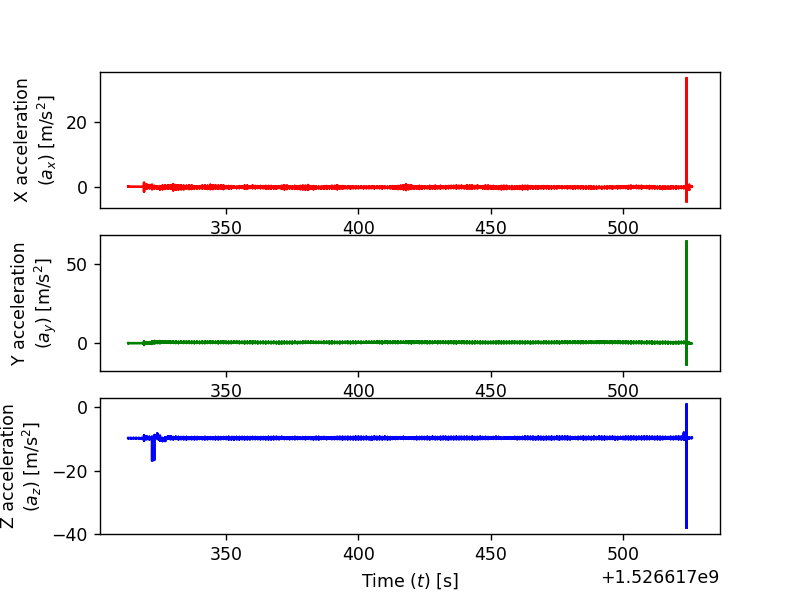

In [12]:
fig,ax = plt.subplots(3,1)

ax[0].plot(imu_df['secs'], imu_df['ax_[m/s2]'], color='r')
ax[1].plot(imu_df['secs'], imu_df['ay_[m/s2]'], color='g')
ax[2].plot(imu_df['secs'], imu_df['az_[m/s2]'], color='b')

ax[0].set_ylabel("X acceleration\n($a_x$) [m/s$^2$]")
ax[1].set_ylabel("Y acceleration\n($a_y$) [m/s$^2$]")
ax[2].set_ylabel("Z acceleration\n($a_z$) [m/s$^2$]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

<IPython.core.display.Javascript object>


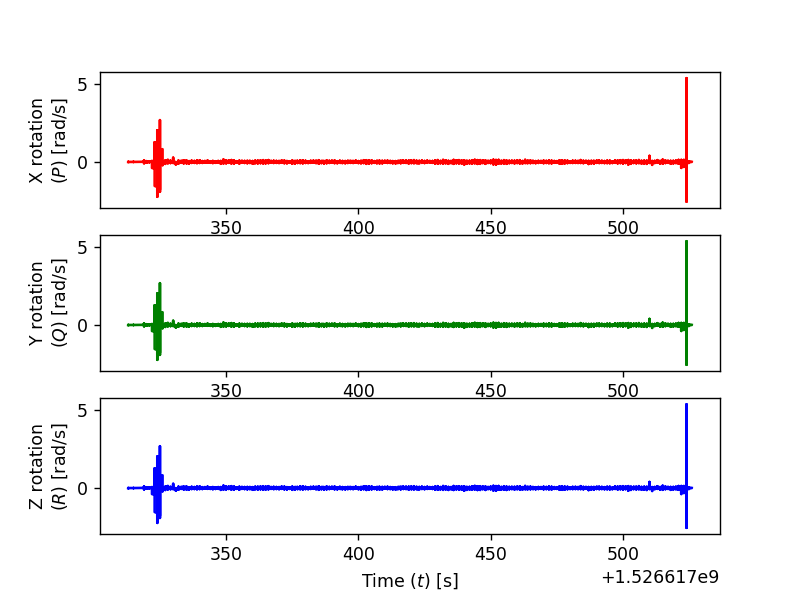

In [13]:
fig,ax = plt.subplots(3,1)

ax[0].plot(imu_df['secs'], imu_df['omegax_[rps]'], color='r')
ax[1].plot(imu_df['secs'], imu_df['omegax_[rps]'], color='g')
ax[2].plot(imu_df['secs'], imu_df['omegax_[rps]'], color='b')

ax[0].set_ylabel("X rotation\n($P$) [rad/s]")
ax[1].set_ylabel("Y rotation\n($Q$) [rad/s]")
ax[2].set_ylabel("Z rotation\n($R$) [rad/s]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

### PWM CSV

In [14]:
url = urlhead + "blackbird_slash_pwm.csv"
pwm_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
pwm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39824 entries, 0 to 39823
Data columns (total 8 columns):
rosbagTimestamp    39824 non-null int64
header             0 non-null float64
seq                39824 non-null int64
stamp              0 non-null float64
secs               39824 non-null int64
nsecs              39824 non-null int64
frame_id           39824 non-null object
pwm                39824 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 2.4+ MB


In [15]:
# Drop empty columns
pwm_df = pwm_df.drop(['header',\
                      'stamp'],\
                     axis=1)

In [16]:
#Rename variables and add units
for i in range(pwm_df.index[-1]):
    pwms = pwm_df.at[i,'pwm'][1:-1].split(", ")
    pwm_df.at[i,'PWM1'] = int(pwms[0])
    pwm_df.at[i,'PWM2'] = int(pwms[1])
    pwm_df.at[i,'PWM3'] = int(pwms[2])
    pwm_df.at[i,'PWM4'] = int(pwms[3])

pwm_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,pwm,PWM1,PWM2,PWM3,PWM4
0,1526617313551168000,1,1526617313,551168000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
1,1526617313556662000,2,1526617313,556662000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
2,1526617313562032000,3,1526617313,562032000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
3,1526617313567452000,4,1526617313,567452000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
4,1526617313572855000,5,1526617313,572855000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0


<IPython.core.display.Javascript object>


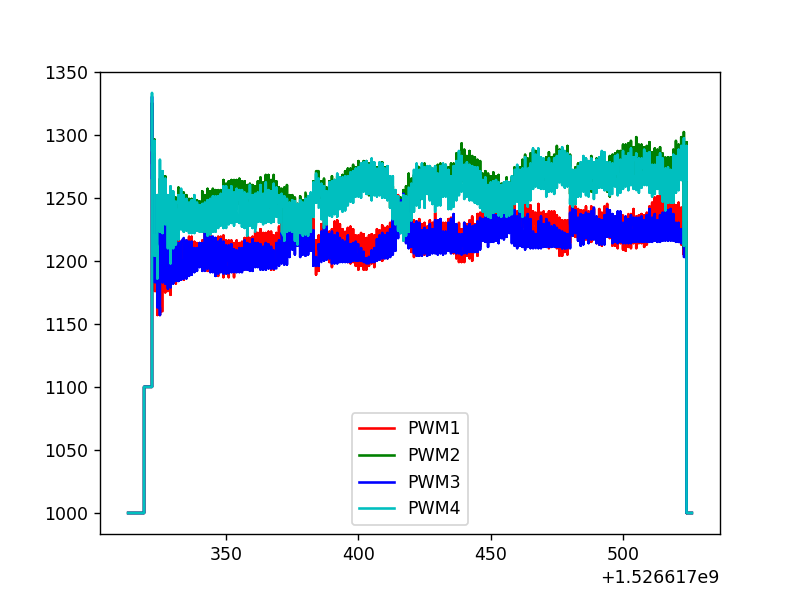

In [17]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(pwm_df['secs'], pwm_df['PWM1'], label="PWM1", color="r")
ax.plot(pwm_df['secs'], pwm_df['PWM2'], label="PWM2", color="g")
ax.plot(pwm_df['secs'], pwm_df['PWM3'], label="PWM3", color="b")
ax.plot(pwm_df['secs'], pwm_df['PWM4'], label="PWM4", color="c")

ax.legend()
plt.show()

### Motor RPM CSV

In [18]:
url = urlhead + "blackbird_slash_rotor_rpm.csv"
motors_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
motors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39825 entries, 0 to 39824
Data columns (total 21 columns):
rosbagTimestamp    39825 non-null int64
header             0 non-null float64
seq                39825 non-null int64
stamp              0 non-null float64
secs               39825 non-null int64
nsecs              39825 non-null int64
frame_id           39825 non-null object
sample_stamp       0 non-null float64
-                  39825 non-null int64
secs.1             39825 non-null int64
nsecs.1            39825 non-null int64
-.1                39825 non-null int64
secs.2             39825 non-null int64
nsecs.2            39825 non-null int64
-.2                39825 non-null int64
secs.3             39825 non-null int64
nsecs.3            39825 non-null object
-.3                0 non-null float64
secs.4             0 non-null float64
nsecs.4            0 non-null float64
rpm                0 non-null float64
dtypes: float64(7), int64(12), object(2)
memory usage: 6.4+ MB


In [19]:
# Drop empty columns
motors_df = motors_df.drop(['header',\
                            'stamp',\
                            'sample_stamp',\
                            '-.3',\
                            'secs.4',\
                            'nsecs.4',\
                            'rpm'],\
                           axis=1)
#Rename variables and add units
motors_df = motors_df.rename(columns={"-"       : "secs_m1",\
                                      "secs.1"  : "nsecs_m1",\
                                      "nsecs.1" : "secs_m2",\
                                      "-.1"     : "nsecs_m2",\
                                      "secs.2"  : "secs_m3",\
                                      "nsecs.2" : "nsecs_m3",\
                                      "-.2"     : "secs_m4",\
                                      "secs.3"  : "nsecs_m4",\
                                      "nsecs.3" : "motor_vec"})

motors_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,secs_m1,nsecs_m1,secs_m2,nsecs_m2,secs_m3,nsecs_m3,secs_m4,nsecs_m4,motor_vec
0,1526617313551167000,1,1526617313,551167000,"""0""",1526617274,767570000,1526617285,167629000,1526617274,767570000,1526617285,167629000,"[0.0, 0.0, 0.0, 0.0]"
1,1526617313556660000,2,1526617313,556660000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]"
2,1526617313562031000,3,1526617313,562031000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]"
3,1526617313567451000,4,1526617313,567451000,"""0""",1526617274,767568000,1526617285,167627000,1526617274,767568000,1526617285,167627000,"[0.0, 0.0, 0.0, 0.0]"
4,1526617313572854000,5,1526617313,572854000,"""0""",1526617274,767567000,1526617285,167626000,1526617274,767567000,1526617285,167626000,"[0.0, 0.0, 0.0, 0.0]"


In [20]:
#Adding in individual motor rpms
for i in range(motors_df.index[-1]):
    rpms = motors_df.at[i,'motor_vec'][1:-1].split(',')
    motors_df.at[i,'rpm1'] = float(rpms[0])
    motors_df.at[i,'rpm2'] = float(rpms[1])
    motors_df.at[i,'rpm3'] = float(rpms[2])
    motors_df.at[i,'rpm4'] = float(rpms[3])

motors_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,secs_m1,nsecs_m1,secs_m2,nsecs_m2,secs_m3,nsecs_m3,secs_m4,nsecs_m4,motor_vec,rpm1,rpm2,rpm3,rpm4
0,1526617313551167000,1,1526617313,551167000,"""0""",1526617274,767570000,1526617285,167629000,1526617274,767570000,1526617285,167629000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0
1,1526617313556660000,2,1526617313,556660000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0
2,1526617313562031000,3,1526617313,562031000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0
3,1526617313567451000,4,1526617313,567451000,"""0""",1526617274,767568000,1526617285,167627000,1526617274,767568000,1526617285,167627000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0
4,1526617313572854000,5,1526617313,572854000,"""0""",1526617274,767567000,1526617285,167626000,1526617274,767567000,1526617285,167626000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


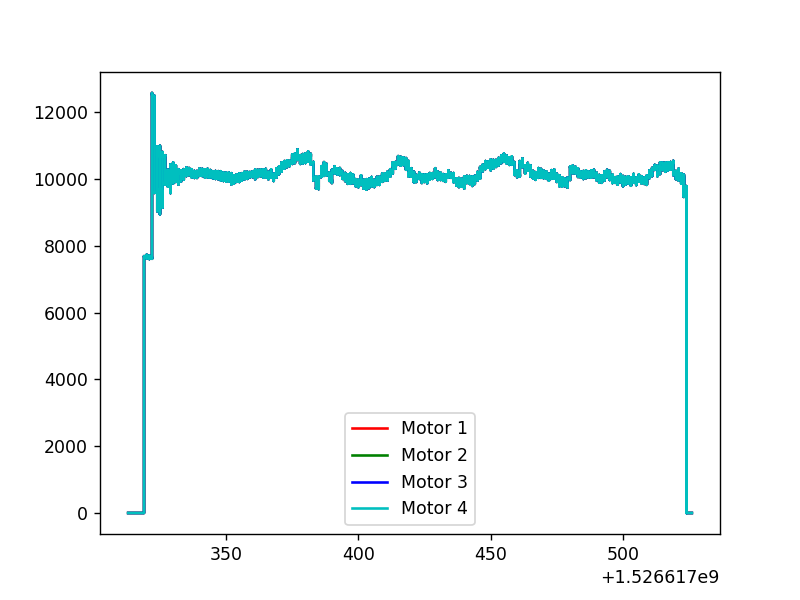

In [21]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 1', color='r')
ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 2', color='g')
ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 3', color='b')
ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 4', color='c')

ax.legend()
plt.show()

### Pose Ref CSV

In [22]:
url = urlhead + "blackbird_slash_pose_ref.csv"
pose_ref_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
pose_ref_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38131 entries, 0 to 38130
Data columns (total 17 columns):
rosbagTimestamp    38131 non-null int64
header             0 non-null float64
seq                38131 non-null int64
stamp              0 non-null float64
secs               38131 non-null int64
nsecs              38131 non-null int64
frame_id           38131 non-null object
pose               0 non-null float64
position           0 non-null float64
x                  38131 non-null float64
y                  38131 non-null float64
z                  38131 non-null float64
orientation        0 non-null float64
x.1                38131 non-null float64
y.1                38131 non-null float64
z.1                38131 non-null float64
w                  38131 non-null float64
dtypes: float64(12), int64(4), object(1)
memory usage: 4.9+ MB


In [23]:
# Drop empty columns
pose_ref_df = pose_ref_df.drop(['header',\
                                'stamp',\
                                'pose',\
                                'position',\
                                'orientation'],\
                               axis=1)

#Rename variables and add units
pose_ref_df = pose_ref_df.rename(columns={"x" : "px_[m]",\
                                          "y" : "py_[m]",\
                                          "z" : "pz_[m]",\
                                          "x.1" : "qx",\
                                          "y.1" : "qy",\
                                          "z.1" : "qz",\
                                          "w" : "qw"})

pose_ref_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38131 entries, 0 to 38130
Data columns (total 12 columns):
rosbagTimestamp    38131 non-null int64
seq                38131 non-null int64
secs               38131 non-null int64
nsecs              38131 non-null int64
frame_id           38131 non-null object
px_[m]             38131 non-null float64
py_[m]             38131 non-null float64
pz_[m]             38131 non-null float64
qx                 38131 non-null float64
qy                 38131 non-null float64
qz                 38131 non-null float64
qw                 38131 non-null float64
dtypes: float64(7), int64(4), object(1)
memory usage: 3.5+ MB


<IPython.core.display.Javascript object>


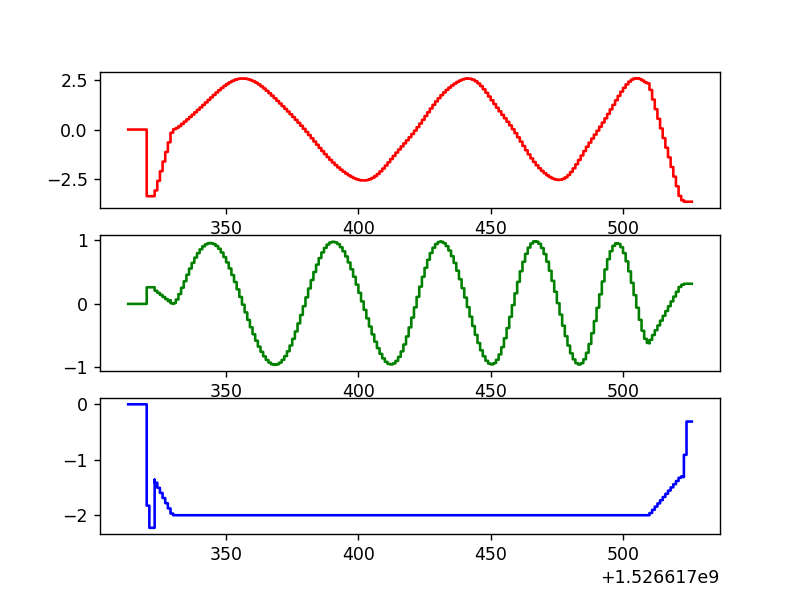

In [24]:
fig,ax = plt.subplots(3,1)

ax[0].plot(pose_ref_df['secs'], pose_ref_df['px_[m]'], label="X", color="r")
ax[1].plot(pose_ref_df['secs'], pose_ref_df['py_[m]'], label="Y", color="g")
ax[2].plot(pose_ref_df['secs'], pose_ref_df['pz_[m]'], label="Z", color="b")

plt.show()

<IPython.core.display.Javascript object>


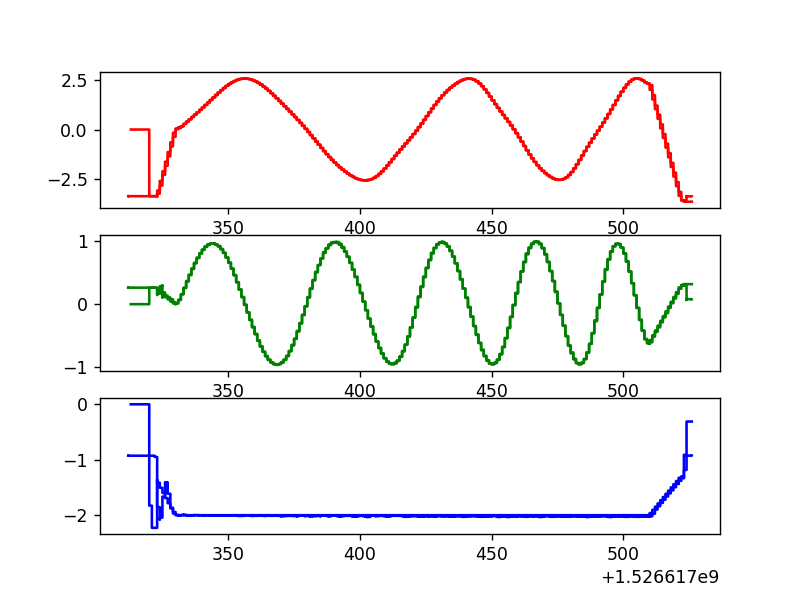

In [25]:
fig,ax = plt.subplots(3,1)

ax[0].plot(pose_ref_df['secs'], pose_ref_df['px_[m]'], label="X", color="r")
ax[1].plot(pose_ref_df['secs'], pose_ref_df['py_[m]'], label="Y", color="g")
ax[2].plot(pose_ref_df['secs'], pose_ref_df['pz_[m]'], label="Z", color="b")
ax[0].plot(pos_and_orien['secs'], pos_and_orien['px_[m]'], color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['py_[m]'], color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['pz_[m]'], color='b')

plt.show()